In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


In [6]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_loss

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


transform = transforms.ToTensor()
train_loader = DataLoader(datasets.MNIST('.', train=True, download=True, transform=transform), batch_size=128, shuffle=True)


model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


for epoch in range(10):
    model.train()
    total_loss = 0
    for batch, _ in train_loader:
        batch = batch.view(-1, 784)  # flatten
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch)
        loss = vae_loss(recon_batch, batch, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.2f}")


Epoch 1, Loss: 9911619.14
Epoch 2, Loss: 7264403.19
Epoch 3, Loss: 6864839.53
Epoch 4, Loss: 6697259.20
Epoch 5, Loss: 6593976.04
Epoch 6, Loss: 6523451.85
Epoch 7, Loss: 6472978.40
Epoch 8, Loss: 6433830.81
Epoch 9, Loss: 6400911.08
Epoch 10, Loss: 6376498.22


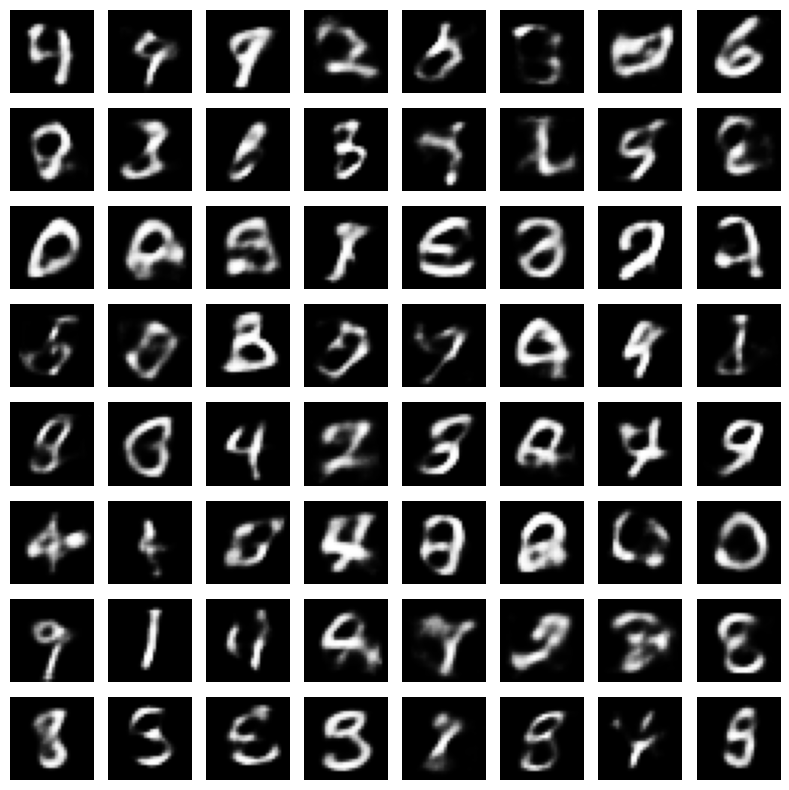

In [11]:
import matplotlib.pyplot as plt
model.eval()
# Sample from prior
with torch.no_grad():
    z = torch.randn(64, 20)  # 64 samples from standard normal
    samples = model.decode(z).view(-1, 1, 28, 28)  # reshape to image format

# Show images in an 8x8 grid
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].squeeze().cpu().numpy(), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()
